In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2017-08-01', '2017-08-07'))

[(72.0, 79.25, 83.0)]


In [10]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set

start_date='2017-08-01'
end_date='2017-08-07'

def calc_temps(start_date,end_date):
    
    return (session.query(func.min(Measurement.tobs), 
                          func.round(
                          func.avg(Measurement.tobs)), 
                          func.max(Measurement.tobs))
                   .filter(Measurement.date >= start_date)
                   .filter(Measurement.date <= end_date)
                   .all())

trip_temp=calc_temps(start_date,end_date)
#print(trip_temp)

trip_temp_df=pd.DataFrame({'start_date': start_date,
                           'end_date': end_date,
                           'min_temp': [trip_temp[0][0]],
                           'avg_temp': [trip_temp[0][1]],
                           'max_temp': [trip_temp[0][2]]
                          })
trip_temp_df.set_index(['start_date','end_date'],inplace=True)
trip_temp_df

,,min_temp,avg_temp,max_temp
start_date,end_date,,,
2017-08-01,2017-08-07,72.0,79.0,83.0


In [11]:
my_trip = calc_temps("2017-08-01", "2017-08-07")
my_trip

[(72.0, 79.0, 83.0)]

In [12]:
trip_temp_df = pd.DataFrame(my_trip, columns=["TMIN", "TAVG", "TMAX"])

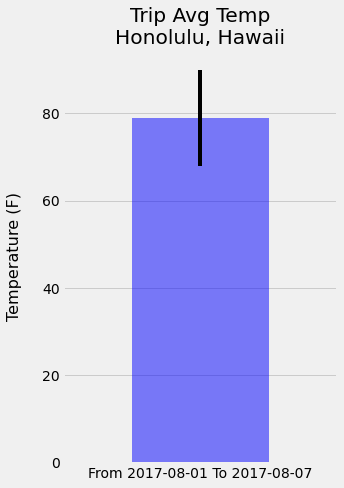

In [13]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_temp_df.plot.bar(y="TAVG", yerr=(trip_temp_df["TMAX"] - trip_temp_df["TMIN"]), 
                    title='Trip Avg Temp\nHonolulu, Hawaii', color="blue", 
                    alpha=0.5, figsize=(5,7), legend=None)
plt.xticks([])
plt.yticks(fontsize=14)
plt.xlabel("From 2017-08-01 To 2017-08-07",fontsize=14,color='black')
plt.ylabel("Temperature (F)",fontsize=16,color='black',labelpad=20)
plt.tight_layout()
plt.savefig("Images/bonus_trip_avg_temp.png")
plt.show()

### Daily Rainfall Average

In [14]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
total_prcp_by_st=(session.query(Measurement.station,Station.name,func.sum(Measurement.prcp),
                                Station.latitude,Station.longitude,Station.elevation)
                         .filter(Measurement.date >= start_date)
                         .filter(Measurement.date <= end_date)
                         .filter(Measurement.station == Station.station)
                         .group_by(Measurement.station)
                         .order_by(func.sum(Measurement.prcp)
                         .desc())
                         .all())

In [15]:
print(f'Daily total rainfall estimates by station for dates between {start_date} and {end_date}.')

total_prcp_by_st_df=pd.DataFrame(total_prcp_by_st,
                                 columns=['station','name',
                                          'total_prcp','latitude',
                                          'longitude','elevation'])
total_prcp_by_st_df

Daily total rainfall estimates by station for dates between 2017-08-01 and 2017-08-07.


,station,name,total_prcp,latitude,longitude,elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",0.36,21.33310,-157.80250,152.4
1,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",0.22,21.52130,-157.83740,7.0
2,USC00519281,"WAIHEE 837.5, HI US",0.06,21.45167,-157.84889,32.9
3,USC00519397,"WAIKIKI 717.2, HI US",0.04,21.27160,-157.81680,3.0
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",0.00,21.33556,-157.71139,19.5


In [16]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [17]:
# Set the start and end date of the trip
# start_date = '2017-08-01'
# end_date = '2017-08-07'

# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Use the start and end date to create a range of dates
# Strip off the year and save a list of strings in the format %m-%d
# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.


trip_dates=["08-01", "08-02", "08-03", "08-04", "08-05", "08-06", "08-07"]

normals=[]

def daily_normals(date):
    sel = [func.min(Measurement.tobs), 
           func.round(func.avg(Measurement.tobs),2), 
           func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

for i in trip_dates:
    normals.append(daily_normals(i)[0])

normals

[(67.0, 75.54, 83.0),
 (68.0, 75.6, 84.0),
 (70.0, 76.61, 85.0),
 (69.0, 76.71, 84.0),
 (69.0, 76.15, 82.0),
 (67.0, 76.25, 83.0),
 (71.0, 77.16, 83.0)]

In [18]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_daily_normals_df=pd.DataFrame(normals,columns=['min_temp','avg_temp','max_temp'],
                                   index=trip_dates)

trip_daily_normals_df.index.name='date'
trip_daily_normals_df

,min_temp,avg_temp,max_temp
date,,,
08-01,67.0,75.54,83.0
08-02,68.0,75.60,84.0
08-03,70.0,76.61,85.0
08-04,69.0,76.71,84.0
08-05,69.0,76.15,82.0
08-06,67.0,76.25,83.0
08-07,71.0,77.16,83.0


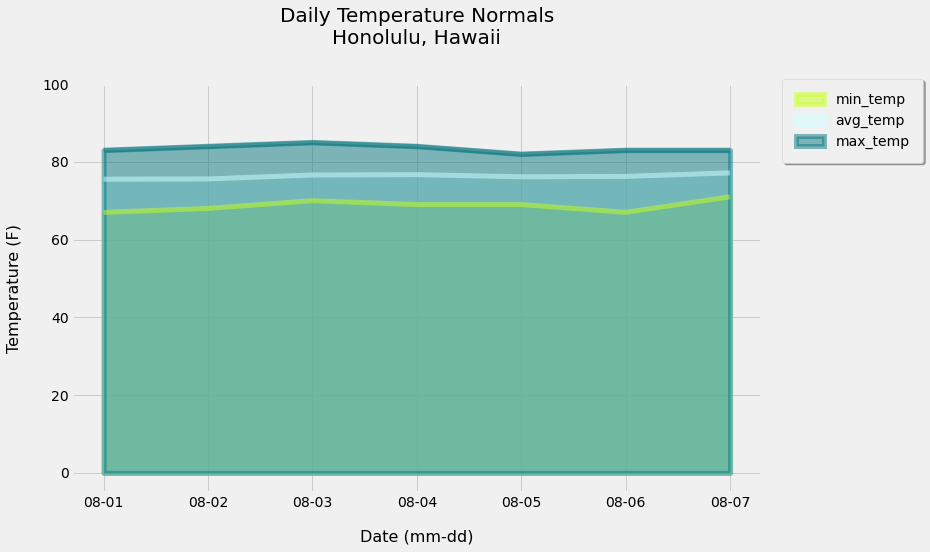

In [19]:
# Plot the daily normals as an area plot with `stacked=False`
plt.rcParams['figure.figsize']=(11,7)
colors=['xkcd:green yellow','xkcd:very light blue','xkcd:deep aqua']
trip_daily_normals_df.plot.area(linewidth=5,stacked=False,rot=0,alpha=0.5,color=colors);

plt.ylim(-5,100)
plt.yticks(size=14)
plt.xticks(fontsize=14)
plt.xlabel('Date (mm-dd)',fontsize=16,color='black',labelpad=20)
plt.ylabel('Temperature (F)',fontsize=16,color='black',labelpad=20)
plt.title('Daily Temperature Normals\nHonolulu, Hawaii',fontsize=20,pad=40)
plt.gca().legend(loc='center left', bbox_to_anchor=(1.02, 0.91),shadow=True,borderpad=1);
plt.savefig("Images/bonus_daily_temp_normals.png")

## Close Session

In [20]:
session.close()